In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('DataBase.csv')
df

,wy,time,roll,az,wz,ay,wx,ax,yaw,pitch
0,0.0,0.79,12352.0,-270.0,1.0,94.0,0.0,-408.0,1677.0,1086.0
1,1.0,0.81,12352.0,-270.0,0.0,93.0,0.0,-407.0,1677.0,1086.0
2,0.0,0.82,12352.0,-270.0,0.0,94.0,0.0,-408.0,1677.0,1086.0
3,0.0,0.83,12352.0,-270.0,0.0,94.0,0.0,-408.0,1677.0,1086.0
4,0.0,0.84,12352.0,-270.0,0.0,94.0,-1.0,-408.0,1677.0,1086.0
...,...,...,...,...,...,...,...,...,...,...
6471,-1.0,71.94,13845.0,-361.0,0.0,125.0,-1.0,-320.0,2445.0,1445.0
6472,-1.0,71.95,13845.0,-362.0,0.0,125.0,-1.0,-319.0,2445.0,1445.0
6473,-1.0,71.96,13845.0,-361.0,0.0,124.0,0.0,-319.0,2445.0,1445.0
6474,-2.0,71.97,13845.0,-361.0,0.0,124.0,0.0,-320.0,2445.0,1445.0


# VERIFICANDO VARIÁVEIS

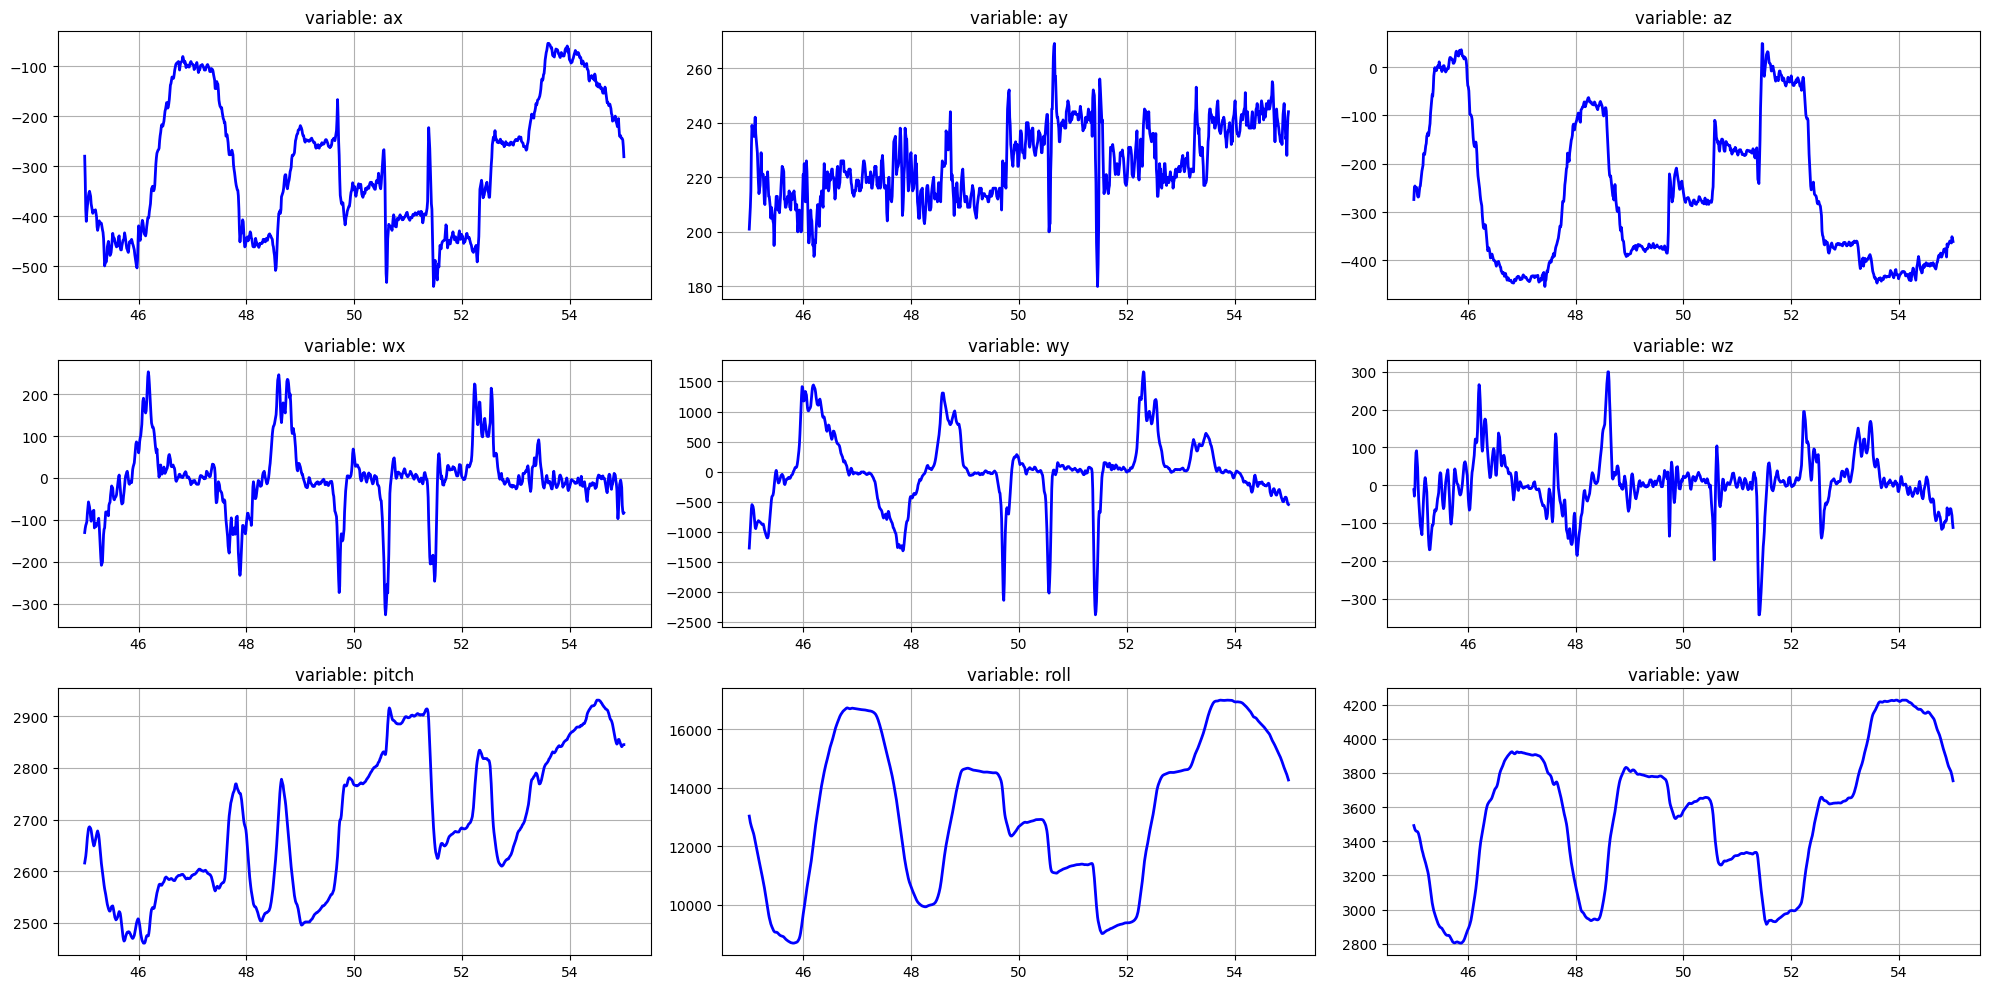

In [33]:
def plotAll(df, limits=None):
    target = df.copy() if not limits else df.loc[(df.time >= limits[0]) & (df.time <= limits[1])]

    plt.figure(figsize=(20, 10))
    for i, key in enumerate(['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'pitch', 'roll', 'yaw']):
        plt.subplot(3, 3, i+1)
        plt.plot(target.time, target[key], color='blue', linewidth=2)
        plt.title(f'variable: {key}'), plt.grid()

    plt.tight_layout()
    plt.show()


plotAll(df, limits=(45, 55))

# VERIFICANDO TEMPO DE AMOSTRAGEM

In [ ]:
START = 50

dx = df.time.diff()[1:].to_numpy()
dx[START:START+100]

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.03, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.03, 0.  , 0.01, 0.01, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [ ]:
def mostFrequent(data, round=3):
    return max(set(dx), key=list(dx).count).round(round)


dt = float(mostFrequent(dx))
dt

0.01

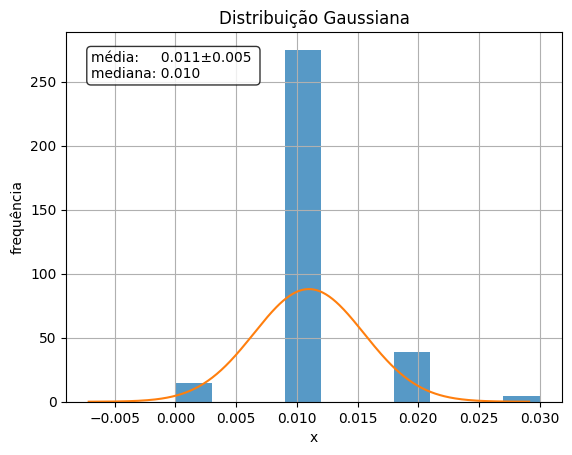

In [ ]:
def gaussian(data):
    data  = np.array(data)
    n     = data.shape[0]
    mu    = data.mean()
    sigma = data.std()

    x  = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)
    y  = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mu)/sigma)**2)
    plt.title(f'Distribuição Gaussiana')
    plt.hist(data, density=True, alpha=0.75)
    plt.plot(x, y)
    
    text = f'média:     {mu:.3f}±{sigma:.3f} \nmediana: {np.median(data):.3f}'
    opts = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, verticalalignment='top', bbox=opts)
    plt.xlabel('x'); plt.ylabel('frequência'); plt.grid()


gaussian(dx)

# APLICANDO FILTROS

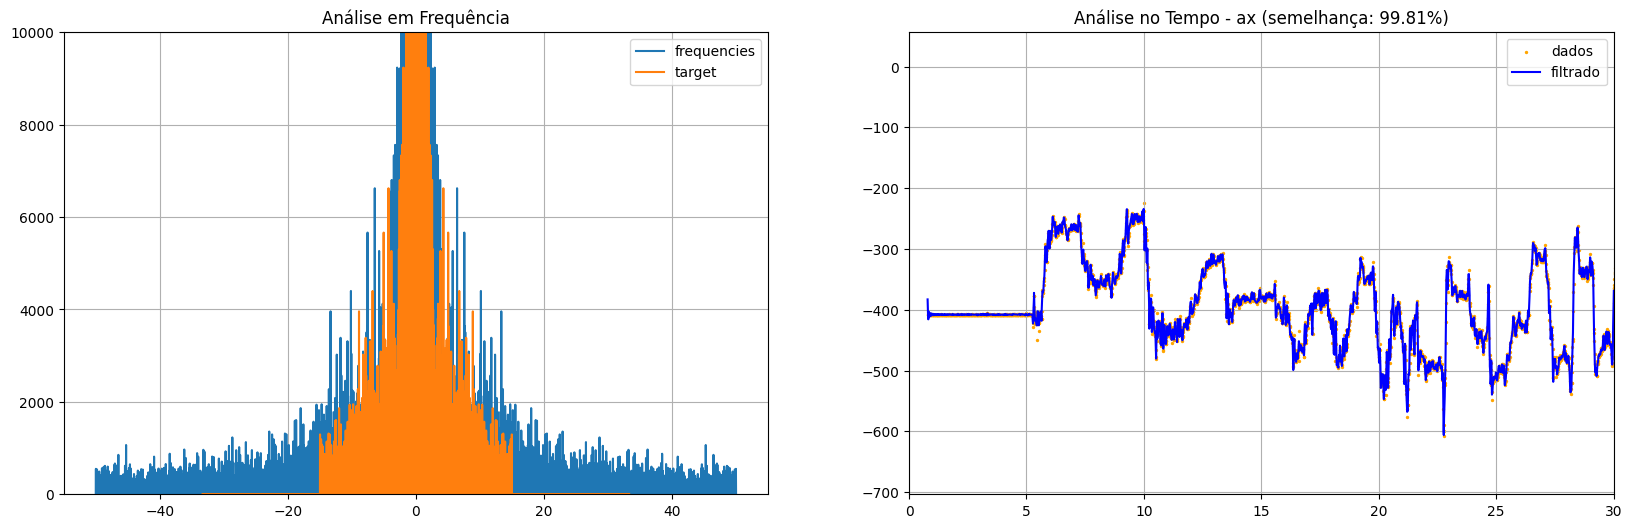

In [ ]:
class LowBandFilter:
    yModel = None
    yMag   = None
    yFreq  = None

    def __init__(self, xData, yData, x_lim=None, f_lim=None):
        self.dt = (xData[2] - xData[0])/2 
        self.xData = xData
        self.yData = yData
        self.x_lim = x_lim
        self.f_lim = f_lim

    def setFrequencies(self):
        self.yMag  = np.fft.fft(self.yData)
        self.yFreq = np.fft.fftfreq(len(self.yData), self.dt)

    def apply(self, Fc=0.1):
        self.setFrequencies()
        allowed = (np.abs(self.yFreq) <= Fc)
        self.yMag[~allowed] = 0
        self.yModel = np.fft.ifft(self.yMag).real
        return self.yModel
    
    def show(self, df, key):
        prec = r2_score(self.yModel, self.yData)

        plt.figure(figsize=(20, 6))
        plt.subplot(1, 2, 1)
        plt.plot(np.fft.fftfreq(len(yData), dt), np.fft.fft(yData).real, label='frequencies')
        plt.plot(self.yFreq, self.yMag.real, label='target')
        plt.title('Análise em Frequência')
        if self.f_lim: plt.ylim(self.f_lim)
        
        plt.grid(), plt.legend()
        plt.subplot(1, 2, 2)
        plt.scatter(df.time, df[key], s=2, color='orange', label='dados')
        plt.plot(xData, self.yModel, color='blue', label='filtrado')
        plt.legend(), plt.grid(); plt.title(f'Análise no Tempo - {key} (semelhança: {prec*100:.2f}%)')
        if self.x_lim: plt.xlim(self.x_lim)


KEY   = 'ax'
xData = df.time
yData = df[KEY].values
filter = LowBandFilter(xData, yData, x_lim=(0, 30), f_lim=(0, 10000))
yModel = filter.apply(Fc=15)
filter.show(df, KEY)